In [1]:
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from IPython.display import display

In [3]:
from sklearn.metrics import mutual_info_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [112]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import mutual_info_score

In [113]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

In [11]:
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text

In [10]:
import pickle

In [5]:
df = pd.read_csv('data/ai4i2020.csv')

### EDA

In [15]:
df.head()

,udi,product_id,type,air_temperature,process_temperature,rotational_speed,torque,tool_wear,machine_failure,twf,hdf,pwf,osf,rnf
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [12]:
df.columns = df.columns.str.strip(' [K]').str.strip(' [rpm').str.strip(' [N').str.strip(' [min').str.lower().str.replace(' ', '_')

In [13]:
df.head(3)

,udi,product_id,type,air_temperature,process_temperature,rotational_speed,torque,tool_wear,machine_failure,twf,hdf,pwf,osf,rnf
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0


In [14]:
df.dtypes

udi                      int64
product_id              object
type                    object
air_temperature        float64
process_temperature    float64
rotational_speed         int64
torque                 float64
tool_wear                int64
machine_failure          int64
twf                      int64
hdf                      int64
pwf                      int64
osf                      int64
rnf                      int64
dtype: object

In [20]:
df.isna().sum()

udi                      0
product_id               0
type                     0
air_temperature_k        0
process_temperature_k    0
rotational_speed_rpm     0
torque_nm                0
tool_wear_min            0
machine_failure          0
twf                      0
hdf                      0
pwf                      0
osf                      0
rnf                      0
dtype: int64

- there are no NA in the dataset

In [54]:
df.machine_failure.sum()

339

In [56]:
df['target'] = df.twf + df.hdf + df.pwf + df.osf + df.rnf

In [60]:
df.target = df.target.astype(bool)

In [61]:
df.target = df.target.astype(int)

In [62]:
df.target

0       0
1       0
2       0
3       0
4       0
       ..
9995    0
9996    0
9997    0
9998    0
9999    0
Name: target, Length: 10000, dtype: int32

In [63]:
df.target.sum()

348

- There is a difference between target and machine_failure columns. It's better to use target as it always has 1 when any of "failure" is 1
#### Let's find out how many values in those columns

In [64]:
for i in ['twf', 'hdf', 'pwf', 'osf', 'rnf', 'target']:
    print(i)
    print(df[i].value_counts(normalize=True))
    print()

twf
0    0.9954
1    0.0046
Name: twf, dtype: float64

hdf
0    0.9885
1    0.0115
Name: hdf, dtype: float64

pwf
0    0.9905
1    0.0095
Name: pwf, dtype: float64

osf
0    0.9902
1    0.0098
Name: osf, dtype: float64

rnf
0    0.9981
1    0.0019
Name: rnf, dtype: float64

target
0    0.9652
1    0.0348
Name: target, dtype: float64



#### Find difference and risk of categorical columns
Categorical is the only one field 'type'

In [65]:
categorical = ['type']

In [66]:
target_rate = df.target.mean()
target_rate

0.0348

In [67]:
df_group = df.groupby('type').target.agg(['mean', 'count'])
df_group['diff'] = df_group['mean'] - target_rate
df_group['risk'] = df_group['mean'] / target_rate

In [68]:
df_group

,mean,count,diff,risk
type,,,,
H,0.023928,1003,-0.010872,0.687592
L,0.040500,6000,0.005700,1.163793
M,0.027027,2997,-0.007773,0.776639


#### Feature importance: Mutual information

In [70]:
mutual_info_score(df.target, df.type)

0.0007650673690752733

- There is a very low mutual impotance of target and type columns

#### Correlations

In [72]:
df.head(1)

,udi,product_id,type,air_temperature,process_temperature,rotational_speed,torque,tool_wear,machine_failure,twf,hdf,pwf,osf,rnf,target
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0,0


In [75]:
numerical = ['air_temperature', 'process_temperature', 'rotational_speed', 'torque', 'tool_wear']

In [76]:
df[numerical].corrwith(df.target).round(2).sort_values(ascending=False)

torque                 0.19
tool_wear              0.11
air_temperature        0.08
process_temperature    0.04
rotational_speed      -0.05
dtype: float64

In [77]:
df[numerical].corrwith(df.twf).round(2).sort_values(ascending=False)

tool_wear              0.12
air_temperature        0.01
process_temperature    0.01
rotational_speed       0.01
torque                -0.01
dtype: float64

In [78]:
df[numerical].corrwith(df.hdf).round(2).sort_values(ascending=False)

air_temperature        0.14
torque                 0.14
process_temperature    0.06
tool_wear             -0.00
rotational_speed      -0.12
dtype: float64

In [79]:
df[numerical].corrwith(df.pwf).round(2).sort_values(ascending=False)

rotational_speed       0.12
torque                 0.08
air_temperature        0.00
process_temperature   -0.00
tool_wear             -0.01
dtype: float64

In [80]:
df[numerical].corrwith(df.osf).round(2).sort_values(ascending=False)

torque                 0.18
tool_wear              0.16
air_temperature        0.00
process_temperature    0.00
rotational_speed      -0.10
dtype: float64

In [81]:
df[numerical].corrwith(df.rnf).round(2).sort_values(ascending=False)

air_temperature        0.02
process_temperature    0.02
torque                 0.02
tool_wear              0.01
rotational_speed      -0.01
dtype: float64

In [82]:
df.corr()

,udi,air_temperature,process_temperature,rotational_speed,torque,tool_wear,machine_failure,twf,hdf,pwf,osf,rnf,target
udi,1.000000,0.117428,0.324428,-0.006615,0.003207,-0.010702,-0.022892,0.009154,-0.022215,-0.023557,-0.000990,-0.005954,-0.024398
air_temperature,0.117428,1.000000,0.876107,0.022670,-0.013778,0.013853,0.082556,0.009955,0.137831,0.003470,0.001988,0.017688,0.084453
process_temperature,0.324428,0.876107,1.000000,0.019277,-0.014061,0.013488,0.035946,0.007315,0.056933,-0.003355,0.004554,0.022279,0.039816
rotational_speed,-0.006615,0.022670,0.019277,1.000000,-0.875027,0.000223,-0.044188,0.010389,-0.121241,0.123018,-0.104575,-0.013088,-0.045483
torque,0.003207,-0.013778,-0.014061,-0.875027,1.000000,-0.003093,0.191321,-0.014662,0.142610,0.083781,0.183465,0.016136,0.191563
tool_wear,-0.010702,0.013853,0.013488,0.000223,-0.003093,1.000000,0.105448,0.115792,-0.001287,-0.009334,0.155894,0.011326,0.105251
machine_failure,-0.022892,0.082556,0.035946,-0.044188,0.191321,0.105448,1.000000,0.362904,0.575800,0.522812,0.531083,0.004516,0.959389
twf,0.009154,0.009955,0.007315,0.010389,-0.014662,0.115792,0.362904,1.000000,-0.007332,0.008577,0.038243,0.030970,0.358013
hdf,-0.022215,0.137831,0.056933,-0.121241,0.142610,-0.001287,0.575800,-0.007332,1.000000,0.018443,0.046396,-0.004706,0.568041
pwf,-0.023557,0.003470,-0.003355,0.123018,0.083781,-0.009334,0.522812,0.008577,0.018443,1.000000,0.115836,-0.004273,0.515767


<AxesSubplot:>

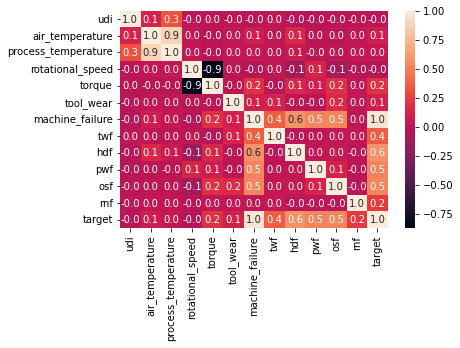

In [83]:
sns.heatmap(df.corr(), annot=True, fmt=".1f")

In [84]:
all_targets = ['twf', 'hdf', 'pwf', 'osf', 'rnf', 'target']

In [85]:
for i in all_targets:
    print(i)
    print(df[i].sum())
    print(df[i].mean())
    print('---')

twf
46
0.0046
---
hdf
115
0.0115
---
pwf
95
0.0095
---
osf
98
0.0098
---
rnf
19
0.0019
---
target
348
0.0348
---


In [86]:
df.head()

,udi,product_id,type,air_temperature,process_temperature,rotational_speed,torque,tool_wear,machine_failure,twf,hdf,pwf,osf,rnf,target
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0,0


In [87]:
del df['udi']
del df['product_id']
del df['machine_failure']

- Delete columns we don't need in df

In [88]:
df.head(2)

,type,air_temperature,process_temperature,rotational_speed,torque,tool_wear,twf,hdf,pwf,osf,rnf,target
0,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0


### Train, validation, test split

In [89]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [90]:
len(df_train), len(df_val), len(df_test)

(6000, 2000, 2000)

In [91]:
df_train

,type,air_temperature,process_temperature,rotational_speed,torque,tool_wear,twf,hdf,pwf,osf,rnf,target
4495,L,302.6,310.4,1359,57.2,67,0,1,0,0,0,1
6470,L,300.4,309.6,1379,54.5,122,0,0,0,0,0,0
2221,L,299.6,309.0,1372,60.4,149,0,0,0,0,0,0
7686,M,300.7,311.7,1504,36.9,229,0,0,0,0,0,0
9419,L,298.0,308.4,1911,22.0,13,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
7586,L,300.4,311.1,1589,35.5,191,0,0,0,0,0,0
8288,M,298.8,310.6,1640,33.8,9,0,0,0,0,0,0
9718,L,298.9,309.9,1517,36.6,117,0,0,0,0,0,0
7562,M,300.3,311.1,1350,58.7,130,0,0,0,0,0,0


In [92]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [93]:
df_train

,type,air_temperature,process_temperature,rotational_speed,torque,tool_wear,twf,hdf,pwf,osf,rnf,target
0,L,302.6,310.4,1359,57.2,67,0,1,0,0,0,1
1,L,300.4,309.6,1379,54.5,122,0,0,0,0,0,0
2,L,299.6,309.0,1372,60.4,149,0,0,0,0,0,0
3,M,300.7,311.7,1504,36.9,229,0,0,0,0,0,0
4,L,298.0,308.4,1911,22.0,13,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
5995,L,300.4,311.1,1589,35.5,191,0,0,0,0,0,0
5996,M,298.8,310.6,1640,33.8,9,0,0,0,0,0,0
5997,L,298.9,309.9,1517,36.6,117,0,0,0,0,0,0
5998,M,300.3,311.1,1350,58.7,130,0,0,0,0,0,0


In [94]:
y_train = df_train.target.values
y_val = df_val.target.values
y_test = df_test.target.values

In [95]:
y_train_twf = df_train.twf.values
y_val_twf = df_val.twf.values
y_test_twf = df_test.twf.values

In [96]:
y_train_hdf = df_train.hdf.values
y_val_hdf = df_val.hdf.values
y_test_hdf = df_test.hdf.values

In [97]:
y_train_pwf = df_train.pwf.values
y_val_pwf = df_val.pwf.values
y_test_pwf = df_test.pwf.values

In [98]:
y_train_osf = df_train.osf.values
y_val_osf = df_val.osf.values
y_test_osf = df_test.osf.values

In [99]:
y_train_rnf = df_train.rnf.values
y_val_rnf = df_val.rnf.values
y_test_rnf = df_test.rnf.values

In [100]:
del df_train['target']
del df_val['target']
del df_test['target']

In [101]:
del df_train['twf']
del df_val['twf']
del df_test['twf']

del df_train['hdf']
del df_val['hdf']
del df_test['hdf']

del df_train['pwf']
del df_val['pwf']
del df_test['pwf']

del df_train['osf']
del df_val['osf']
del df_test['osf']

del df_train['rnf']
del df_val['rnf']
del df_test['rnf']

In [102]:
df_train.head(3)

,type,air_temperature,process_temperature,rotational_speed,torque,tool_wear
0,L,302.6,310.4,1359,57.2,67
1,L,300.4,309.6,1379,54.5,122
2,L,299.6,309.0,1372,60.4,149


- In this project the model will be created for predicting the **"target" only** (not others).

### One-hot encoding

In [103]:
dv = DictVectorizer(sparse=False)

train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

In [104]:
X_train

array([[3.026e+02, 3.104e+02, 1.359e+03, ..., 0.000e+00, 1.000e+00,
        0.000e+00],
       [3.004e+02, 3.096e+02, 1.379e+03, ..., 0.000e+00, 1.000e+00,
        0.000e+00],
       [2.996e+02, 3.090e+02, 1.372e+03, ..., 0.000e+00, 1.000e+00,
        0.000e+00],
       ...,
       [2.989e+02, 3.099e+02, 1.517e+03, ..., 0.000e+00, 1.000e+00,
        0.000e+00],
       [3.003e+02, 3.111e+02, 1.350e+03, ..., 0.000e+00, 0.000e+00,
        1.000e+00],
       [3.006e+02, 3.106e+02, 1.454e+03, ..., 0.000e+00, 1.000e+00,
        0.000e+00]])

### Training logistic regression

In [105]:
model = LogisticRegression(solver='liblinear')
model.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

In [106]:
model.intercept_[0]

-0.013967495067394076

In [107]:
model.coef_[0].round(3)

array([ 0.796, -0.877,  0.011,  0.012,  0.264, -0.271,  0.311, -0.053])

In [108]:
y_pred = model.predict(X_val)

In [109]:
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [110]:
y_pred = model.predict_proba(X_val)[:, 1]
y_pred

array([0.00074935, 0.03084307, 0.05349892, ..., 0.00563861, 0.0239297 ,
       0.00433648])

#### Test the model on the test dataset

In [131]:
dicts_full_train = df_full_train[categorical + numerical].to_dict(orient='records')

In [132]:
dicts_full_train[:1]

[{'type': 'M',
  'air_temperature': 300.1,
  'process_temperature': 309.6,
  'rotational_speed': 1625,
  'torque': 38.0,
  'tool_wear': 46}]

In [133]:
len(dicts_full_train)

8000

In [134]:
dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(dicts_full_train)

In [135]:
y_full_train = df_full_train.target.values

In [136]:
df_full_train.target.value_counts()

0    7719
1     281
Name: target, dtype: int64

In [137]:
model.fit(X_full_train, y_full_train)

LogisticRegression(solver='liblinear')

In [138]:
dicts_test = df_test[categorical + numerical].to_dict(orient='records')
X_test = dv.transform(dicts_test)

In [139]:
y_pred = model.predict_proba(X_test)[:, 1]
y_pred

array([0.00665555, 0.01783834, 0.19675615, ..., 0.0042186 , 0.01395155,
       0.03447484])

### Evaluation Metrics for Classification
Metric - function that compares the predictions with the actual values and outputs a single number that tells how good the predictions are

In [116]:
accuracy_score(y_val, y_pred >= 0.5)

0.974

In [117]:
thresholds = np.linspace(0, 1, 21)

scores = []

for t in thresholds:
    score = accuracy_score(y_val, y_pred >= t)
    print('%.2f %.3f' % (t, score))
    scores.append(score)

0.00 0.031
0.05 0.862
0.10 0.929
0.15 0.952
0.20 0.962
0.25 0.965
0.30 0.970
0.35 0.970
0.40 0.972
0.45 0.973
0.50 0.974
0.55 0.974
0.60 0.974
0.65 0.973
0.70 0.973
0.75 0.972
0.80 0.971
0.85 0.970
0.90 0.969
0.95 0.969
1.00 0.969


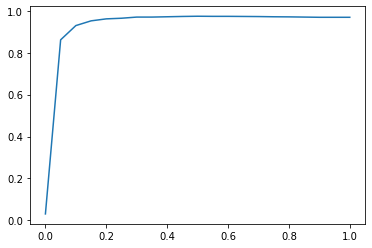

In [118]:
plt.plot(thresholds, scores)

#### Confusion table

In [141]:
actual_positive = (y_test == 1)
actual_negative = (y_test == 0)

In [142]:
t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

In [143]:
predict_positive.sum()

18

In [144]:
predict_negative.sum()

1982

In [145]:
actual_positive.sum()

67

In [146]:
actual_negative.sum()

1933

In [147]:
y_pred.shape

(2000,)

In [148]:
tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()

fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

In [149]:
confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])
confusion_matrix

array([[1929,    4],
       [  53,   14]])

In [150]:
(confusion_matrix / confusion_matrix.sum()).round(2)

array([[0.96, 0.  ],
       [0.03, 0.01]])

### Precision and Recall

In [151]:
p = tp / (tp + fp)
p

0.7777777777777778

In [152]:
r = tp / (tp + fn)
r

0.208955223880597

### ROC Curves

In [153]:
tpr = tp / (tp + fn)
tpr

0.208955223880597

In [154]:
fpr = fp / (fp + tn)
fpr

0.0020693222969477496

In [155]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

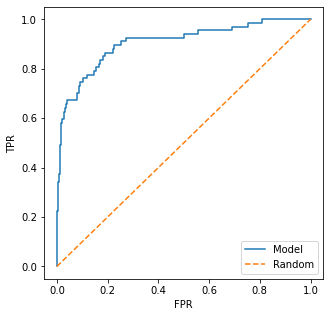

In [156]:
plt.figure(figsize=(5, 5))

plt.plot(fpr, tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

### ROC AUC
test on the test dataset

In [157]:
roc_auc_score(y_test, y_pred)

0.9048729451552378

In [158]:
auc(fpr, tpr)

0.9048729451552378

In [159]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc(fpr, tpr)

0.9048729451552378

### Decision trees

In [160]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [161]:
y_pred = dt.predict_proba(X_val)[:, 1]

In [162]:
y_pred.shape

(2000,)

In [163]:
y_train.shape

(6000,)

In [164]:
roc_auc_score(y_val, y_pred)

0.816388694696894

In [165]:
y_pred = dt.predict_proba(X_train)[:, 1]
roc_auc_score(y_train, y_pred)

1.0

This means model is overfitted

In [166]:
dt = DecisionTreeClassifier(max_depth=2)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2)

In [167]:
y_pred = dt.predict_proba(X_train)[:, 1]
auc = roc_auc_score(y_train, y_pred)
print('train:', auc)

y_pred = dt.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
print('val:', auc)

train: 0.6373168599071591
val: 0.6420736376044476


In [168]:
print(export_text(dt, feature_names=dv.get_feature_names()))

|--- torque <= 62.35
|   |--- torque <= 13.15
|   |   |--- class: 1
|   |--- torque >  13.15
|   |   |--- class: 0
|--- torque >  62.35
|   |--- torque <= 65.00
|   |   |--- class: 0
|   |--- torque >  65.00
|   |   |--- class: 1



C:\Users\HP\miniconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


#### Decision tree - parameters tuning

In [169]:
depths = [1, 2, 3, 4, 5, 6, 10, 15, 20, None]

for depth in depths: 
    dt = DecisionTreeClassifier(max_depth=depth)
    dt.fit(X_train, y_train)
    
    y_pred = dt.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    
    print('%4s -> %.3f' % (depth, auc))

   1 -> 0.609
   2 -> 0.642
   3 -> 0.800
   4 -> 0.804
   5 -> 0.840
   6 -> 0.875
  10 -> 0.858
  15 -> 0.815
  20 -> 0.809
None -> 0.816


- The best auc with max_depth 5, 6, 10

In [170]:
scores = []

for depth in [5, 6, 10]:
    for s in [1, 5, 10, 15, 20, 500, 100, 200]:
        dt = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=s)
        dt.fit(X_train, y_train)

        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        
        scores.append((depth, s, auc))

In [171]:
columns = ['max_depth', 'min_samples_leaf', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

In [172]:
df_scores

,max_depth,min_samples_leaf,auc
0,5,1,0.840149
1,5,5,0.839492
2,5,10,0.853624
3,5,15,0.853187
4,5,20,0.852409
5,5,500,0.868550
6,5,100,0.929338
7,5,200,0.904770
8,6,1,0.875462
9,6,5,0.889777


In [173]:
df_scores_pivot = df_scores.pivot(index='min_samples_leaf', columns=['max_depth'], values=['auc'])
df_scores_pivot

auc                    
max_depth               5         6         10
min_samples_leaf                              
1                 0.840149  0.875462  0.866736
5                 0.839492  0.889777  0.872944
10                0.853624  0.935471  0.923845
15                0.853187  0.934489  0.942799
20                0.852409  0.926296  0.919896
100               0.929338  0.942333  0.940923
200               0.904770  0.905248  0.902647
500               0.868550  0.869253  0.869253

<AxesSubplot:xlabel='None-max_depth', ylabel='min_samples_leaf'>

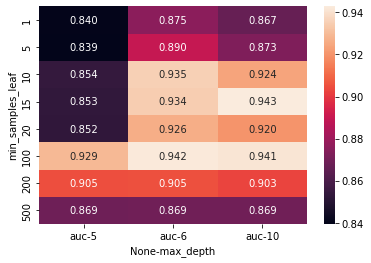

In [174]:
sns.heatmap(df_scores_pivot, annot=True, fmt=".3f")

- The best auc with max_depth=10, min_samples_leaf=15

In [175]:
dt = DecisionTreeClassifier(max_depth=10, min_samples_leaf=15)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=15)

In [176]:
y_pred = dt.predict_proba(X_train)[:, 1]
auc = roc_auc_score(y_train, y_pred)
print('train:', auc)

y_pred = dt.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
print('val:', auc)

train: 0.9873965178007944
val: 0.9429533273411232


In [177]:
print(export_text(dt, feature_names=dv.get_feature_names()))

|--- torque <= 62.35
|   |--- torque <= 13.15
|   |   |--- class: 1
|   |--- torque >  13.15
|   |   |--- rotational_speed <= 1380.50
|   |   |   |--- air_temperature <= 301.55
|   |   |   |   |--- tool_wear <= 201.50
|   |   |   |   |   |--- tool_wear <= 186.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- tool_wear >  186.50
|   |   |   |   |   |   |--- torque <= 56.30
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- torque >  56.30
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- tool_wear >  201.50
|   |   |   |   |   |--- torque <= 53.10
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- torque >  53.10
|   |   |   |   |   |   |--- class: 1
|   |   |   |--- air_temperature >  301.55
|   |   |   |   |--- process_temperature <= 310.75
|   |   |   |   |   |--- air_temperature <= 301.95
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- air_temperature >  301.95
|   |   |   |   |   |   |--- air_temperature <=

C:\Users\HP\miniconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### Random forest

In [178]:
scores = []

for n in range(10, 201, 10):
    rf = RandomForestClassifier(n_estimators=n, random_state=1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    
    scores.append((n, auc))

In [179]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'auc'])

In [180]:
df_scores.round(3).sort_values('auc', ascending=False).head(10)

,n_estimators,auc
19,200,0.939
17,180,0.939
16,170,0.939
6,70,0.939
14,150,0.939
13,140,0.939
18,190,0.938
15,160,0.938
12,130,0.938
11,120,0.937


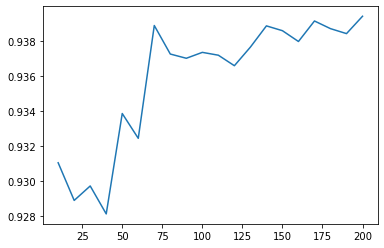

In [181]:
plt.plot(df_scores.n_estimators, df_scores.auc)

In [182]:
scores = []

for d in [5, 10, 15]:
    for n in range(50, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=d,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((d, n, auc))

In [183]:
columns = ['max_depth', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

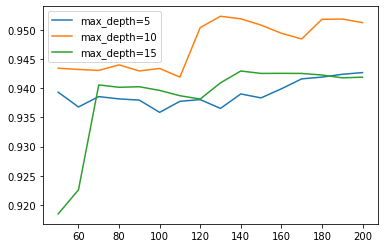

In [184]:
for d in [5, 10, 15]:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             label='max_depth=%d' % d)

plt.legend()

In [185]:
max_depth = 10

In [186]:
scores = []

for s in [1, 3, 5, 10, 50]:
    for n in range(50, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=max_depth,
                                    min_samples_leaf=s,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((s, n, auc))

In [187]:
columns = ['min_samples_leaf', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

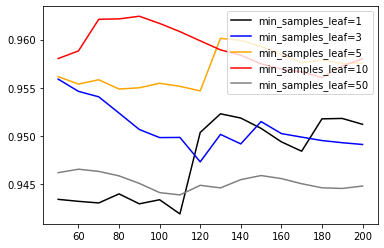

In [188]:
colors = ['black', 'blue', 'orange', 'red', 'grey']
values = [1, 3, 5, 10, 50]

for s, col in zip(values, colors):
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             color=col,
             label='min_samples_leaf=%d' % s)

plt.legend()

In [189]:
min_samples_leaf = 10

In [190]:
rf = RandomForestClassifier(n_estimators=80,
                            max_depth=max_depth,
                            min_samples_leaf=min_samples_leaf,
                            random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=10, n_estimators=80,
                       random_state=1)

In [191]:
y_pred = rf.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
auc

0.9621575285462232

### Gradient boosting trees

In [161]:
dv.get_feature_names_out()

array(['air_temperature_k', 'process_temperature_k',
       'rotational_speed_rpm', 'tool_wear_min', 'torque_nm', 'type=H',
       'type=L', 'type=M'], dtype=object)

In [162]:
features = dv.get_feature_names_out()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [163]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model_xgb = xgb.train(xgb_params, dtrain, num_boost_round=10)

In [164]:
y_pred = model_xgb.predict(dval)

In [166]:
roc_auc_score(y_val, y_pred)

0.9578631112886581

To evaluate model on each step we have to create a watchlist

In [167]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [168]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5, #print with every 5 steps
                  evals=watchlist)

[0]	train-auc:0.95538	val-auc:0.94244
[5]	train-auc:0.98075	val-auc:0.95552
[10]	train-auc:0.98432	val-auc:0.95763
[15]	train-auc:0.99618	val-auc:0.95636
[20]	train-auc:0.99794	val-auc:0.95426
[25]	train-auc:0.99900	val-auc:0.95086
[30]	train-auc:0.99943	val-auc:0.94958
[35]	train-auc:0.99966	val-auc:0.94634
[40]	train-auc:0.99991	val-auc:0.94730
[45]	train-auc:0.99998	val-auc:0.94570
[50]	train-auc:0.99999	val-auc:0.94619
[55]	train-auc:1.00000	val-auc:0.94547
[60]	train-auc:1.00000	val-auc:0.94485
[65]	train-auc:1.00000	val-auc:0.94303
[70]	train-auc:1.00000	val-auc:0.94073
[75]	train-auc:1.00000	val-auc:0.94054
[80]	train-auc:1.00000	val-auc:0.93970
[85]	train-auc:1.00000	val-auc:0.93919
[90]	train-auc:1.00000	val-auc:0.93905
[95]	train-auc:1.00000	val-auc:0.93871
[100]	train-auc:1.00000	val-auc:0.93926
[105]	train-auc:1.00000	val-auc:0.93850
[110]	train-auc:1.00000	val-auc:0.93826
[115]	train-auc:1.00000	val-auc:0.93758
[120]	train-auc:1.00000	val-auc:0.93853
[125]	train-auc:1.0000

In [169]:
%%capture output 

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5, #print with every 5 steps
                  evals=watchlist)

In [170]:
output.stdout

'[0]\ttrain-auc:0.95538\tval-auc:0.94244\n[5]\ttrain-auc:0.98075\tval-auc:0.95552\n[10]\ttrain-auc:0.98432\tval-auc:0.95763\n[15]\ttrain-auc:0.99618\tval-auc:0.95636\n[20]\ttrain-auc:0.99794\tval-auc:0.95426\n[25]\ttrain-auc:0.99900\tval-auc:0.95086\n[30]\ttrain-auc:0.99943\tval-auc:0.94958\n[35]\ttrain-auc:0.99966\tval-auc:0.94634\n[40]\ttrain-auc:0.99991\tval-auc:0.94730\n[45]\ttrain-auc:0.99998\tval-auc:0.94570\n[50]\ttrain-auc:0.99999\tval-auc:0.94619\n[55]\ttrain-auc:1.00000\tval-auc:0.94547\n[60]\ttrain-auc:1.00000\tval-auc:0.94485\n[65]\ttrain-auc:1.00000\tval-auc:0.94303\n[70]\ttrain-auc:1.00000\tval-auc:0.94073\n[75]\ttrain-auc:1.00000\tval-auc:0.94054\n[80]\ttrain-auc:1.00000\tval-auc:0.93970\n[85]\ttrain-auc:1.00000\tval-auc:0.93919\n[90]\ttrain-auc:1.00000\tval-auc:0.93905\n[95]\ttrain-auc:1.00000\tval-auc:0.93871\n[100]\ttrain-auc:1.00000\tval-auc:0.93926\n[105]\ttrain-auc:1.00000\tval-auc:0.93850\n[110]\ttrain-auc:1.00000\tval-auc:0.93826\n[115]\ttrain-auc:1.00000\tval-au

In [171]:
s = output.stdout

In [172]:
print(s[:250])

[0]	train-auc:0.95538	val-auc:0.94244
[5]	train-auc:0.98075	val-auc:0.95552
[10]	train-auc:0.98432	val-auc:0.95763
[15]	train-auc:0.99618	val-auc:0.95636
[20]	train-auc:0.99794	val-auc:0.95426
[25]	train-auc:0.99900	val-auc:0.95086
[30]	train-auc:0.9


Temp

In [173]:
s.split('\n')[:5]

['[0]\ttrain-auc:0.95538\tval-auc:0.94244',
 '[5]\ttrain-auc:0.98075\tval-auc:0.95552',
 '[10]\ttrain-auc:0.98432\tval-auc:0.95763',
 '[15]\ttrain-auc:0.99618\tval-auc:0.95636',
 '[20]\ttrain-auc:0.99794\tval-auc:0.95426']

In [174]:
line = s.split('\n')[0]
line

'[0]\ttrain-auc:0.95538\tval-auc:0.94244'

In [175]:
line.split('\t')

['[0]', 'train-auc:0.95538', 'val-auc:0.94244']

In [176]:
num_iter, train_auc, val_auc = line.split('\t')

In [177]:
int(num_iter.strip('[]'))

0

##### Very good pattern!

In [178]:
float(train_auc.split(':')[1])

0.95538

In [179]:
float(val_auc.split(':')[1])

0.94244

In [180]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [181]:
df_score = parse_xgb_output(output)

In [182]:
df_score.head(15)

,num_iter,train_auc,val_auc
0,0,0.95538,0.94244
1,5,0.98075,0.95552
2,10,0.98432,0.95763
3,15,0.99618,0.95636
4,20,0.99794,0.95426
5,25,0.99900,0.95086
6,30,0.99943,0.94958
7,35,0.99966,0.94634
8,40,0.99991,0.94730
9,45,0.99998,0.94570


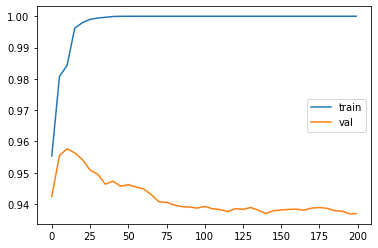

In [183]:
plt.plot(df_score.num_iter, df_score.train_auc, label='train')
plt.plot(df_score.num_iter, df_score.val_auc, label='val')
plt.legend()

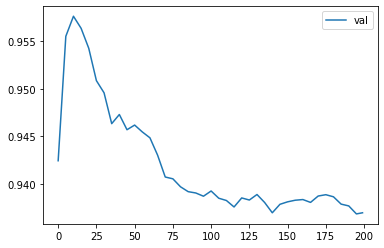

In [184]:
plt.plot(df_score.num_iter, df_score.val_auc, label='val')
plt.legend()

### XGBoost parameter tuning

In [185]:
xgb_params = {
    'eta': 1.0, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model_ = xgb.train(xgb_params, dtrain, num_boost_round=200)

In [186]:
y_pred_xgb = model.predict(dval)
roc_auc_score(y_val, y_pred_xgb)

0.9369652784713205

- This is a roc_auc_score with default parameters

#### XGBoost parameters tuning

Let's make the fit with different eta
- 0.01
- 0.05
- 0.1
- 0.3
- 0.5
- 1.0

In [187]:
scores = {}

In [230]:
%%capture output

xgb_params = {
    'eta': 1.0, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [231]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key

'eta=1.0'

In [232]:
scores.keys()

dict_keys(['eta=0.01', 'eta=0.05', 'eta=0.1', 'eta=0.3', 'eta=0.5', 'eta=1.0'])

In [233]:
scores.items()

dict_items([('eta=0.01',     num_iter  train_auc  val_auc
0          0    0.95538  0.94244
1          5    0.95528  0.94158
2         10    0.96288  0.94405
3         15    0.96360  0.94505
4         20    0.96387  0.94548
5         25    0.96403  0.94577
6         30    0.96470  0.94636
7         35    0.96494  0.94694
8         40    0.96724  0.94681
9         45    0.96742  0.94693
10        50    0.96768  0.95507
11        55    0.96809  0.95557
12        60    0.97283  0.95631
13        65    0.97338  0.95633
14        70    0.97368  0.95649
15        75    0.97395  0.95711
16        80    0.97448  0.95696
17        85    0.97452  0.95709
18        90    0.97460  0.95701
19        95    0.97465  0.95725
20       100    0.97470  0.95722
21       105    0.97485  0.95733
22       110    0.97488  0.95746
23       115    0.97497  0.95741
24       120    0.97496  0.95725
25       125    0.97504  0.95725
26       130    0.97537  0.95669
27       135    0.97554  0.95656
28       140    0.

In [234]:
scores['eta=0.01'].head(10)

,num_iter,train_auc,val_auc
0,0,0.95538,0.94244
1,5,0.95528,0.94158
2,10,0.96288,0.94405
3,15,0.96360,0.94505
4,20,0.96387,0.94548
5,25,0.96403,0.94577
6,30,0.96470,0.94636
7,35,0.96494,0.94694
8,40,0.96724,0.94681
9,45,0.96742,0.94693


In [235]:
scores

{'eta=0.01':     num_iter  train_auc  val_auc
 0          0    0.95538  0.94244
 1          5    0.95528  0.94158
 2         10    0.96288  0.94405
 3         15    0.96360  0.94505
 4         20    0.96387  0.94548
 5         25    0.96403  0.94577
 6         30    0.96470  0.94636
 7         35    0.96494  0.94694
 8         40    0.96724  0.94681
 9         45    0.96742  0.94693
 10        50    0.96768  0.95507
 11        55    0.96809  0.95557
 12        60    0.97283  0.95631
 13        65    0.97338  0.95633
 14        70    0.97368  0.95649
 15        75    0.97395  0.95711
 16        80    0.97448  0.95696
 17        85    0.97452  0.95709
 18        90    0.97460  0.95701
 19        95    0.97465  0.95725
 20       100    0.97470  0.95722
 21       105    0.97485  0.95733
 22       110    0.97488  0.95746
 23       115    0.97497  0.95741
 24       120    0.97496  0.95725
 25       125    0.97504  0.95725
 26       130    0.97537  0.95669
 27       135    0.97554  0.95656
 2

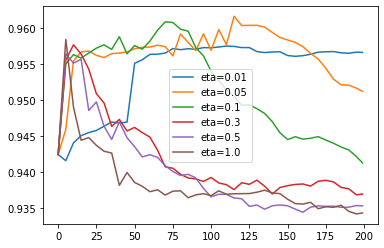

In [241]:
for key, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=key)
plt.legend()

- So, eta = 0.05 is the best.
- Let's find out what the best max_depth is
- max_depth = 3, 4, 6, 8, 10

In [248]:
scores1 = {}

In [265]:
%%capture output

xgb_params = {
    'eta': 0.05, 
    'max_depth': 10,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [266]:
key1 = 'max_depth=%s' % (xgb_params['max_depth'])
scores1[key1] = parse_xgb_output(output)
key1

'max_depth=10'

In [267]:
scores1.keys()

dict_keys(['max_depth=3', 'max_depth=4', 'max_depth=6', 'max_depth=8', 'max_depth=10'])

In [268]:
scores1

{'max_depth=3':     num_iter  train_auc  val_auc
 0          0    0.83468  0.80043
 1          5    0.92515  0.90956
 2         10    0.93758  0.91353
 3         15    0.95474  0.93532
 4         20    0.95678  0.93652
 5         25    0.96230  0.94856
 6         30    0.96300  0.94902
 7         35    0.96818  0.95352
 8         40    0.96957  0.95420
 9         45    0.96984  0.95438
 10        50    0.97231  0.95429
 11        55    0.97273  0.95442
 12        60    0.97300  0.95492
 13        65    0.97525  0.95139
 14        70    0.97583  0.95232
 15        75    0.97798  0.95369
 16        80    0.97800  0.95952
 17        85    0.97949  0.95912
 18        90    0.98144  0.95616
 19        95    0.98076  0.95761
 20       100    0.98065  0.95800
 21       105    0.98117  0.95800
 22       110    0.98301  0.95799
 23       115    0.98316  0.95768
 24       120    0.98339  0.95749
 25       125    0.98364  0.95705
 26       130    0.98386  0.95721
 27       135    0.98406  0.95740

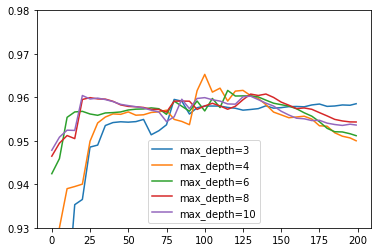

In [282]:
for key, df_score in scores1.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=key)
plt.ylim(0.93, 0.98)
plt.legend()

- So, max_depth = 4 is the best
- Let's find out what the best min_child_weight is
- min_child_weight = 1, 10, 30

In [272]:
scores2 = {}

In [279]:
%%capture output

xgb_params = {
    'eta': 0.05, 
    'max_depth': 4,
    'min_child_weight': 30,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [280]:
key = 'min_child_weight=%s' % (xgb_params['min_child_weight'])
scores2[key] = parse_xgb_output(output)
key

'min_child_weight=30'

In [281]:
scores2.keys()

dict_keys(['min_child_weight=1', 'min_child_weight=10', 'min_child_weight=30'])

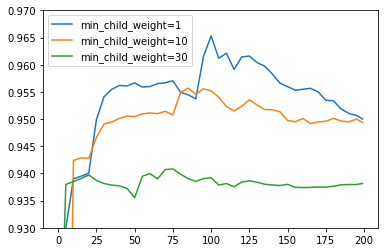

In [284]:
for key, df_score in scores2.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=key)

plt.ylim(0.93, 0.97)
plt.legend()

- So, min_child_weight = 1 is the best
#### Final XGB Model

In [292]:
xgb_params = {
    'eta': 0.05, 
    'max_depth': 4,
    'min_child_weight': 10,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

[0]	train-auc:0.89333	val-auc:0.83364
[5]	train-auc:0.90589	val-auc:0.85271
[10]	train-auc:0.95736	val-auc:0.94238
[15]	train-auc:0.96020	val-auc:0.94287
[20]	train-auc:0.95950	val-auc:0.94277
[25]	train-auc:0.96281	val-auc:0.94664
[30]	train-auc:0.96781	val-auc:0.94910
[35]	train-auc:0.96846	val-auc:0.94947
[40]	train-auc:0.96947	val-auc:0.95012
[45]	train-auc:0.96975	val-auc:0.95055
[50]	train-auc:0.97183	val-auc:0.95045
[55]	train-auc:0.97221	val-auc:0.95096
[60]	train-auc:0.97429	val-auc:0.95112
[65]	train-auc:0.97623	val-auc:0.95101
[70]	train-auc:0.98072	val-auc:0.95143
[75]	train-auc:0.98146	val-auc:0.95076
[80]	train-auc:0.98214	val-auc:0.95490
[85]	train-auc:0.98161	val-auc:0.95567
[90]	train-auc:0.98141	val-auc:0.95458
[95]	train-auc:0.98131	val-auc:0.95557
[100]	train-auc:0.98168	val-auc:0.95519
[105]	train-auc:0.98203	val-auc:0.95403
[110]	train-auc:0.98240	val-auc:0.95231
[115]	train-auc:0.98280	val-auc:0.95150
[120]	train-auc:0.98307	val-auc:0.95236
[125]	train-auc:0.9837

In [297]:
xgb_params = {
    'eta': 0.05, 
    'max_depth': 4,
    'min_child_weight': 1,
    
    'colsample_bytree': 1, #default
    'subsample': 1, #default
    'lambda': 1, #default
    'alpha': 0, #default

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=110)

In [298]:
y_pred_xgb = model.predict(dval)
roc_auc_score(y_val, y_pred_xgb)

0.9587452977795533

## Selecting the best model

In [300]:
model = LogisticRegression(solver='liblinear')
model.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

In [302]:
y_pred_lr = model.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred_lr)

0.8741469423083325

In [305]:
dt = DecisionTreeClassifier(max_depth=10, min_samples_leaf=15)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=15)

In [306]:
y_pred_dt = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred_dt)

0.9429533273411232

In [307]:
rf = RandomForestClassifier(n_estimators=80,
                            max_depth=max_depth,
                            min_samples_leaf=min_samples_leaf,
                            random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=10, n_estimators=80,
                       random_state=1)

In [308]:
y_pred_rf = rf.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred_rf)

0.9621575285462232

In [309]:
xgb_params = {
    'eta': 0.05, 
    'max_depth': 4,
    'min_child_weight': 1,
    
    'colsample_bytree': 1, #default
    'subsample': 1, #default
    'lambda': 1, #default
    'alpha': 0, #default

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=110)

In [310]:
y_pred_xgb = model.predict(dval)
roc_auc_score(y_val, y_pred_xgb)

0.9587452977795533

#### So, RF has the best roc_auc_score

In [311]:
df_full_train

,type,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,twf,hdf,pwf,osf,rnf,target
2694,M,300.1,309.6,1625,38.0,46,0,0,0,0,0,0
5140,M,304.3,313.6,1585,32.1,202,0,0,0,0,0,0
2568,L,299.6,309.2,1450,43.1,160,0,0,0,0,0,0
3671,M,302.3,311.7,1486,39.6,147,0,0,0,0,0,0
7427,L,300.0,311.4,1634,31.9,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2895,M,300.7,309.6,1473,48.1,87,0,0,0,0,0,0
7813,L,300.0,311.5,1455,41.7,130,0,0,0,0,0,0
905,L,295.6,306.1,1474,41.2,156,0,0,0,0,0,0
5192,L,303.9,313.1,1310,62.9,130,0,0,0,0,0,0


### Test the RF model on the test dataset

In [312]:
df_full_train = df_full_train.reset_index(drop=True)

In [314]:
y_full_train = df_full_train.target.values

In [315]:
del df_full_train['target']

In [316]:
dicts_full_train = df_full_train.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(dicts_full_train)

dicts_test = df_test.to_dict(orient='records')
X_test = dv.transform(dicts_test)

In [317]:
rf = RandomForestClassifier(n_estimators=80,
                            max_depth=max_depth,
                            min_samples_leaf=min_samples_leaf,
                            random_state=1)
rf.fit(X_full_train, y_full_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=10, n_estimators=80,
                       random_state=1)

In [318]:
y_pred_rf_test = rf.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, y_pred_rf_test)

0.9399549073051708

#### Save file

In [192]:
output_file = 'project1_model_FR.bin'

In [193]:
with open(output_file, 'wb') as f_out:
    pickle.dump((dv, rf), f_out)